# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [2]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("bikes_rent.csv")
df.sample(5)

Saving bikes_rent.csv to bikes_rent.csv


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
449,2,1,3,0,0,0,2,17.937500,21.87440,88.0833,14.791925,6.612394,4996
690,4,1,11,0,3,1,1,14.486653,18.24460,61.3750,6.917482,3.092303,5146
708,4,1,12,0,0,0,2,15.750847,19.50730,90.5417,10.584325,4.731482,3228
650,4,1,10,0,5,1,1,17.937500,21.65355,53.9167,15.751164,7.041200,7282
358,1,0,12,0,0,0,1,11.266103,13.99805,68.1304,10.391097,4.645104,754


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

In [3]:
df_features = df.columns[:-1]
df_target = df.columns[-1]

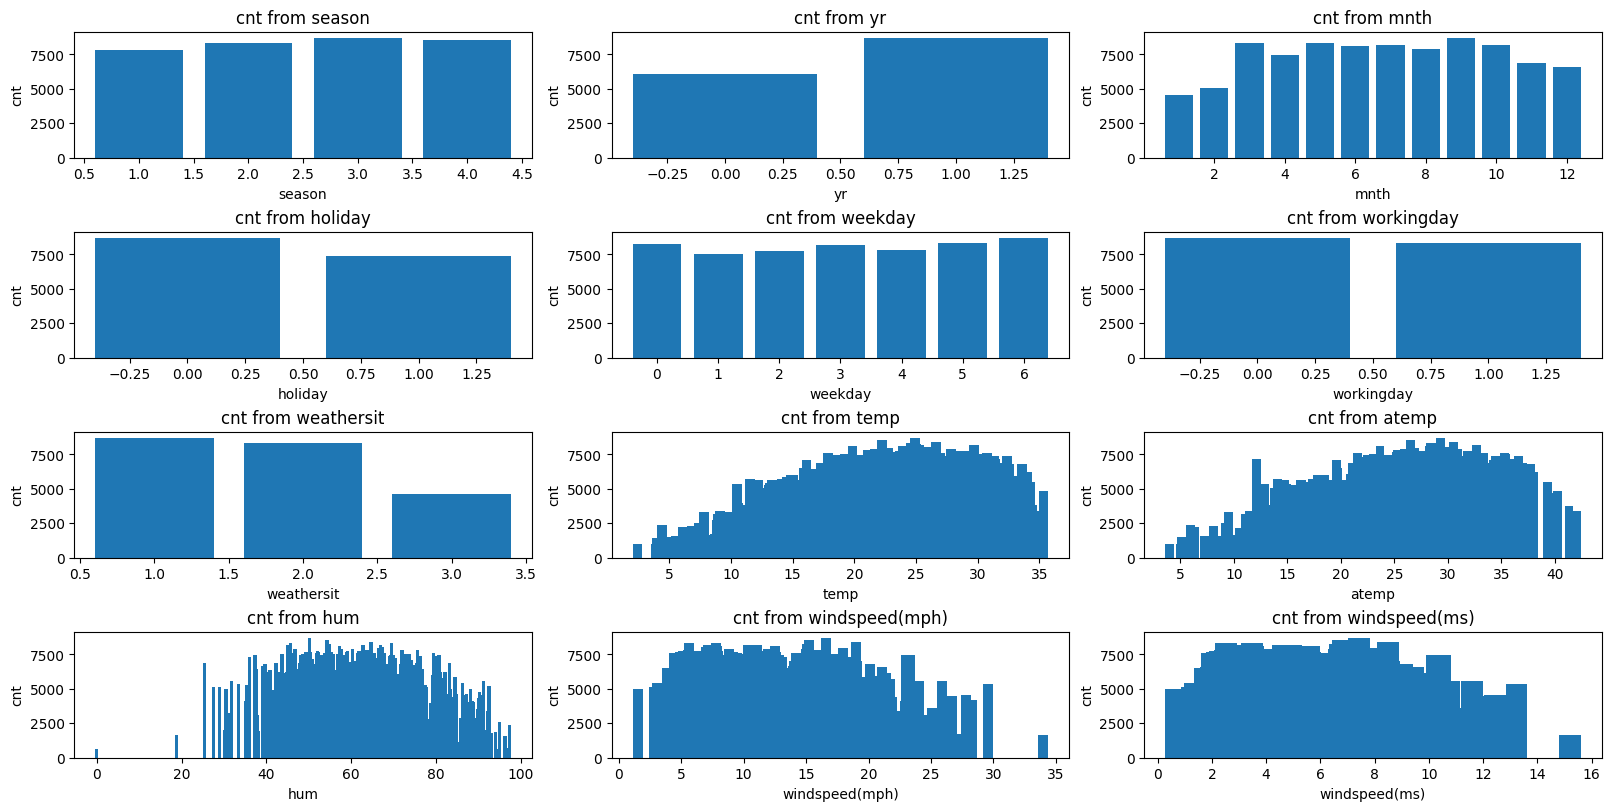

In [4]:
import seaborn as sns

def plot_series(ax, df, xlabel, ylabel):
  xs = df[xlabel]
  ys =  df[ylabel]
  ax.set_title(f'{ylabel} from {xlabel}')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.bar(xs, ys)

cols = 3
fig, axs = plt.subplots( len(df_features) // cols, cols, figsize=(16,8), layout='constrained')

for ax, feature in zip(axs.flat, df_features):
 plot_series(ax, df, feature, df_target  )

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

1. Кількості прокатів від місяця залежить лінійно: починаючи з січня до березня кількість прокатів збільшується, з березня до вересня тримається приблизно на одному рівні, з вересня до грудня зменшується.
2. weathersit, windspeed

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [5]:
df[df_features].corr()
df[df_features].corrwith(df[df_target])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [6]:
pair_corr =["temp", "atemp", "hum","windspeed(mph)", "windspeed(ms)"]
for corr in pair_corr:
  print()
  print(df[[corr,"cnt"]].corr())


          temp       cnt
temp  1.000000  0.627494
cnt   0.627494  1.000000

          atemp       cnt
atemp  1.000000  0.631066
cnt    0.631066  1.000000

          hum       cnt
hum  1.000000 -0.100659
cnt -0.100659  1.000000

                windspeed(mph)       cnt
windspeed(mph)        1.000000 -0.234545
cnt                  -0.234545  1.000000

               windspeed(ms)       cnt
windspeed(ms)       1.000000 -0.234545
cnt                -0.234545  1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [7]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [10]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [11]:
linear_reg = LinearRegression()
linear_reg.fit(X, y)
for f,w in zip(df.columns, linear_reg.coef_):
  print(f"{f}: {w}")

season: 570.8637960129914
yr: 1021.9653779400622
mnth: -141.3017451148728
holiday: -86.7593446245368
weekday: 137.22506441350538
workingday: 56.391881775973005
weathersit: -330.2264620440312
temp: 367.48373260182126
atemp: 585.5493861188597
hum: -145.61430569885857
windspeed(mph): 12457138390688.885
windspeed(ms): -12457138390887.346


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [12]:
from sklearn import model_selection, datasets, linear_model, metrics

lasso_regressor = linear_model.Lasso(random_state=12)
lasso_regressor.fit(X,y)
print(f"{lasso_regressor.coef_.shape=}")
print(f"{lasso_regressor.score(X, y)=}")
print("\nLasso weigths:\n")
for f, w in zip(df.columns, lasso_regressor.coef_):
  print(f"{f:15}: {w.round(4)}")
print(f"\n{lasso_regressor.intercept_=}")

lasso_regressor.coef_.shape=(12,)
lasso_regressor.score(X, y)=0.800239476118262

Lasso weigths:

season         : 560.2416
yr             : 1019.4635
mnth           : -128.7306
holiday        : -86.1528
weekday        : 137.3479
workingday     : 55.2124
weathersit     : -332.3699
temp           : 376.3632
atemp          : 576.5308
hum            : -144.1292
windspeed(mph) : -197.1397
windspeed(ms)  : -0.0

lasso_regressor.intercept_=4504.3488372093025


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [13]:
ridge_regressor = linear_model.Ridge(random_state=12)
ridge_regressor.fit(X, y)

print(f"{ridge_regressor.coef_.shape=}")
print(f"{ridge_regressor.score(X, y)=}")
print("\nRidge weigths:\n")
for f, w in zip(df.columns, ridge_regressor.coef_):
  print(f"{f:15}: {w.round(4)}")
print(f"\n{ridge_regressor.intercept_=}")

ridge_regressor.coef_.shape=(12,)
ridge_regressor.score(X, y)=0.8002417905136303

Ridge weigths:

season         : 563.0646
yr             : 1018.9484
mnth           : -131.8733
holiday        : -86.7461
weekday        : 138.0051
workingday     : 55.9031
weathersit     : -332.3498
temp           : 386.4579
atemp          : 566.347
hum            : -145.0713
windspeed(mph) : -99.2594
windspeed(ms)  : -99.2594

ridge_regressor.intercept_=4504.3488372093025


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [14]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor.set_params(alpha=alpha)
    lasso_regressor.fit(X,y)
    coefs_lasso.append(lasso_regressor.coef_)
    print(f"\n{alpha=}, {coefs_lasso[-1][-1].round(6)=}")

    ridge_regressor.set_params(alpha=alpha)
    ridge_regressor.fit(X,y)
    coefs_ridge.append(ridge_regressor.coef_)
    print(f"{alpha=}, {coefs_ridge[-1][-1].round(6)=}")

# Конвертація списків в np.array.
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print(f"{coefs_lasso.shape=}")
print(f"{coefs_ridge.shape=}")


alpha=1, coefs_lasso[-1][-1].round(6)=-0.0
alpha=1, coefs_ridge[-1][-1].round(6)=-99.259441

alpha=51, coefs_lasso[-1][-1].round(6)=-0.0
alpha=51, coefs_ridge[-1][-1].round(6)=-101.627315

alpha=101, coefs_lasso[-1][-1].round(6)=-0.0
alpha=101, coefs_ridge[-1][-1].round(6)=-102.101671

alpha=151, coefs_lasso[-1][-1].round(6)=-0.0
alpha=151, coefs_ridge[-1][-1].round(6)=-102.005376

alpha=201, coefs_lasso[-1][-1].round(6)=-0.0
alpha=201, coefs_ridge[-1][-1].round(6)=-101.586385

alpha=251, coefs_lasso[-1][-1].round(6)=-0.0
alpha=251, coefs_ridge[-1][-1].round(6)=-100.964711

alpha=301, coefs_lasso[-1][-1].round(6)=-0.0
alpha=301, coefs_ridge[-1][-1].round(6)=-100.20862

alpha=351, coefs_lasso[-1][-1].round(6)=-0.0
alpha=351, coefs_ridge[-1][-1].round(6)=-99.360661

alpha=401, coefs_lasso[-1][-1].round(6)=-0.0
alpha=401, coefs_ridge[-1][-1].round(6)=-98.449064

alpha=451, coefs_lasso[-1][-1].round(6)=-0.0
alpha=451, coefs_ridge[-1][-1].round(6)=-97.493434
coefs_lasso.shape=(10, 12)
coef

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

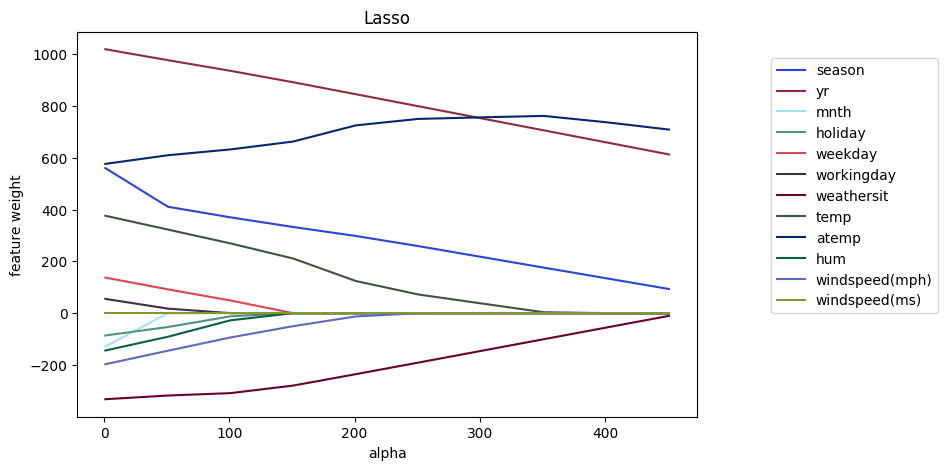

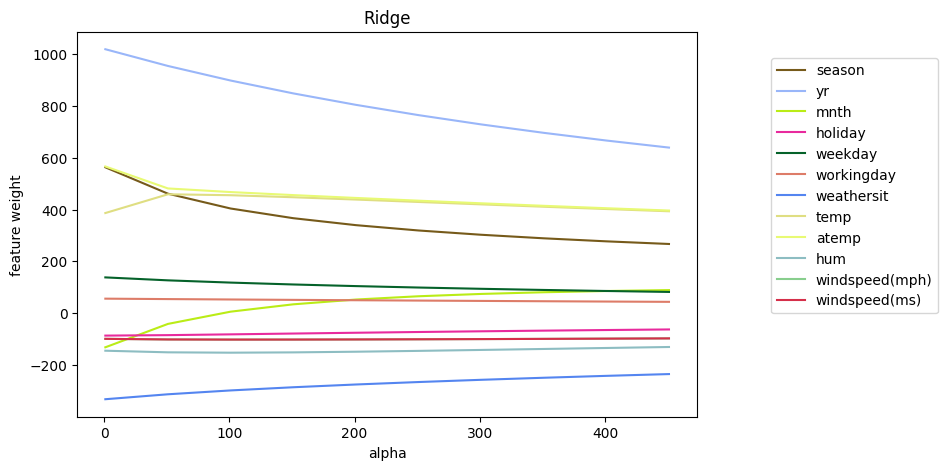

In [15]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

1. Lasso агресивніше зменшує ваги при одному й тому самому alpha.
2. Якщо alpha зробити дуже великим, ваги Lasso менше будуть впливати. Чим більше значення alpha, тим менше рівень впливу.
3. Для Lasso так. Для Ridge ні.
4. Для відбору неінформативних ознак підійде Lasso (ознака швидше перестає впливати).

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [16]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    m_id = np.argmin(y)
    m_y = np.min(y)
    m_x = x[m_id]
    plt.text(m_x, m_y, f"min: {int(m_x)}x{int(m_y)}", ha="center")

    plt.grid()
    plt.show()

regressor.coef_.shape=(12,)
regressor.alphas.shape=(20,)
regressor.mse_path_.shape=(20, 3)
regressor.alphas_=array([96, 91, 86, 81, 76, 71, 66, 61, 56, 51, 46, 41, 36, 31, 26, 21, 16,
       11,  6,  1])


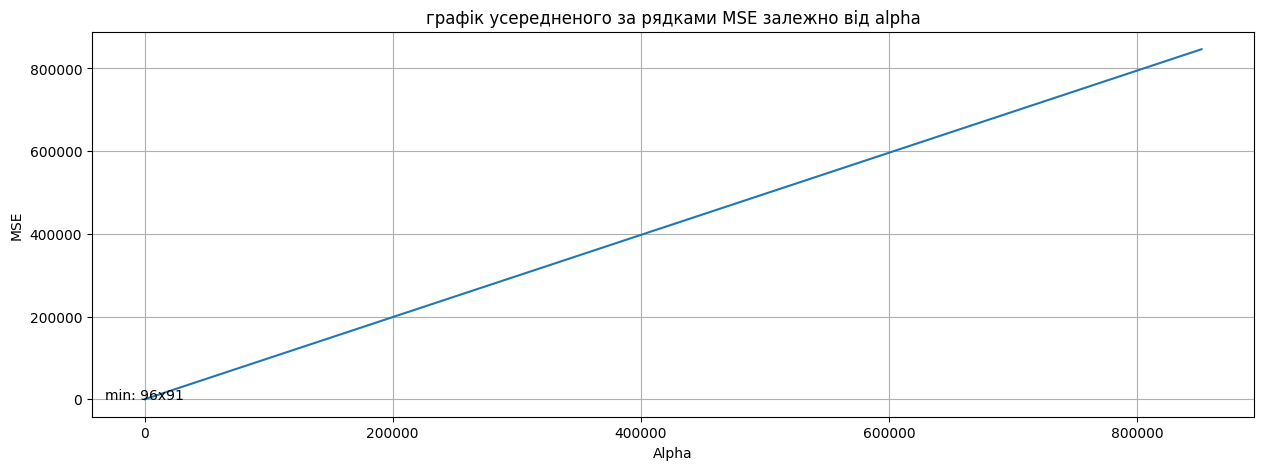

In [17]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(random_state=12, alphas=alphas, cv=3)
regressor.fit(X, y)
print(f"{regressor.coef_.shape=}")
print(f"{regressor.alphas.shape=}")
print(f"{regressor.mse_path_.shape=}")
print(f"{regressor.alphas_=}")

mse_values = np.mean(regressor.mse_path_, axis=1)
# print(f"{mse_values=}")

data = np.vstack((regressor.alphas_, mse_values))
# print(f"{data=}")
create_plot(data,'графік усередненого за рядками MSE залежно від alpha','Alpha','MSE')

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


In [18]:
print("Alphas with minimum MSE:")
print(f"{regressor.mse_path_.shape=}")


min_values = np.min(regressor.mse_path_, axis=0)
print(f"{min_values=}")
min_idx = np.argmin(regressor.mse_path_, axis=0)
print(f"{min_idx=}")
alphas = []
for i, idx in enumerate(min_idx):
  mse = min_values[i]
  alpha = regressor.alphas_[idx]
  alphas.append(alpha)
  print(f"{idx}: Alpha = {alpha}, MSE = {mse}")

Alphas with minimum MSE:
regressor.mse_path_.shape=(20, 3)
min_values=array([733725.76040522, 799433.16736917, 796979.89551936])
min_idx=array([18, 19,  9])
18: Alpha = 6, MSE = 733725.7604052249
19: Alpha = 1, MSE = 799433.1673691692
9: Alpha = 51, MSE = 796979.8955193626


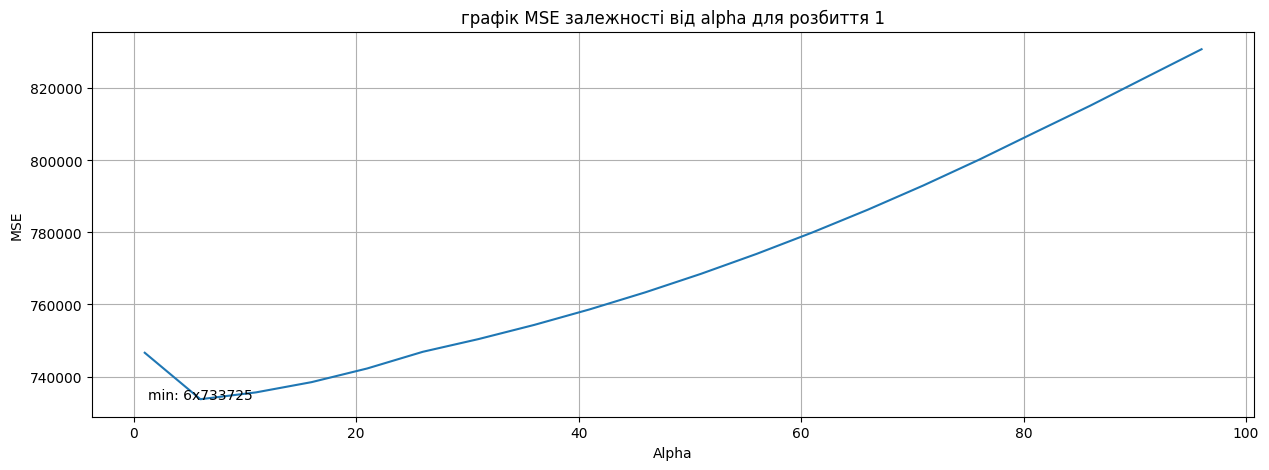

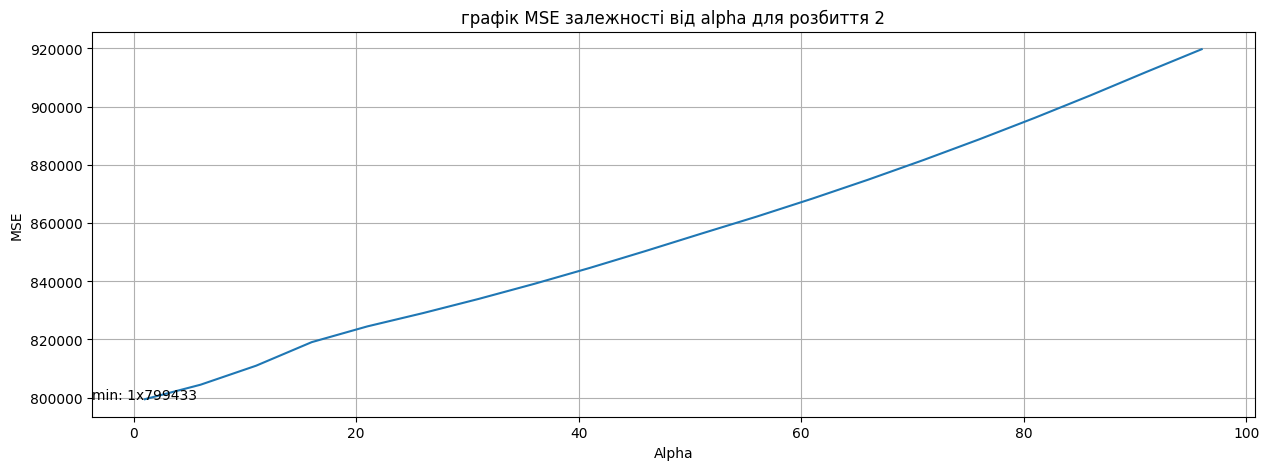

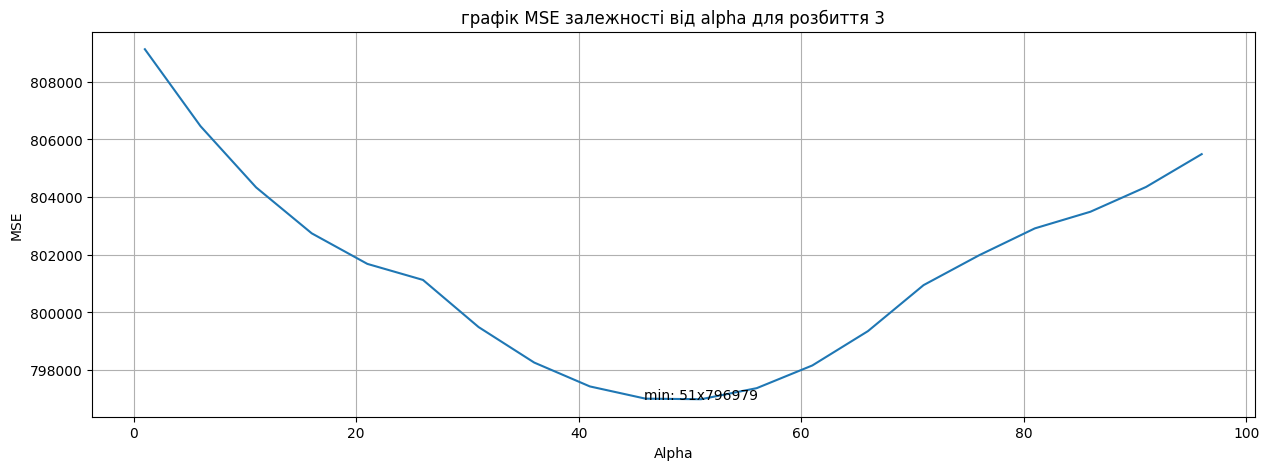

In [21]:
def create_plot_min(data, title, xlabel, ylabel, figsize=None, min=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # x = list(map(lambda e: e[0], data))
    # y = list(map(lambda e: e[1], data))
    x = data[0]
    y = data[1]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.text(min[0], min[1], f"min: {int(min[0])}x{int(min[1])}", ha="center")

    plt.grid()
    plt.show()

for col in range(regressor.mse_path_.shape[1]):
  data = np.vstack((regressor.alphas_, regressor.mse_path_[:,col]))
  create_plot_min(data,f"графік MSE залежноcті від alpha для розбиття {col+1}","Alpha","MSE",min=(alphas[col], min_values[col]))

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

In [22]:
print(f"{regressor.coef_.shape=}")
for f,w in zip(df.columns, regressor.coef_):
  print(f"{f:15}: {w.round(4)}")

regressor.coef_.shape=(12,)
season         : 532.019
yr             : 1015.0602
mnth           : -100.0395
holiday        : -83.294
weekday        : 132.5045
workingday     : 51.5571
weathersit     : -330.5599
temp           : 370.6799
atemp          : 581.3969
hum            : -140.0074
windspeed(mph) : -191.7714
windspeed(ms)  : -0.0


In [23]:
data_coef = pd.DataFrame(regressor.coef_,index=df.columns[:-1], columns=["Weight"])
data_coef[data_coef > 0].dropna().sort_values(by=['Weight'],ascending=False).head(4)

,Weight
yr,1015.060223
atemp,581.396931
season,532.018983
temp,370.679855


__Відповідь:__

In [ ]:
  Для yr бракує даних щоб оцінити залежність; atemp, season, temp - залежність є.
  Так. можливо вважати,  що чим більше значення цих ознак, то більше людей захочуть взяти велосипеди.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

In [24]:
data_coef[data_coef < 0].dropna().abs().sort_values(by=['Weight'],ascending=False).head(3)

,Weight
weathersit,330.559857
windspeed(mph),191.771408
hum,140.007406


__Відповідь:__  Так, можливо вважати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

In [25]:
data_coef[data_coef.abs() < 1e-03].dropna()

,Weight
windspeed(ms),-2.685470e-08


__Відповідь:__ модель виключила їх із моделі тому, що ця ознака є повторненням ознаки windsped тільки в інших одиницях вимірювання.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.